In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

# Load the dataset

In [15]:
data = pd.read_csv("2019-Oct.csv")

In [17]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.8+ GB


In [21]:
data.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

## Dataset Overview

The dataset consists of **42,448,764** entries and **9** columns. Below is a detailed description of each column:

| # | Column Name    | Data Type | Description |
|---|--------------|-----------|-------------|
| 0 | **event_time** | object (string) | The timestamp when the event occurred. It should be converted to a datetime format for better analysis. |
| 1 | **event_type** | object (string) | Describes the type of user action, such as "view", "cart", or "purchase". |
| 2 | **product_id** | int64 | A unique identifier for each product. |
| 3 | **category_id** | int64 | A numerical ID representing the product category. |
| 4 | **category_code** | object (string) | A hierarchical category code that describes the product category in a readable format. Some values may be missing. |
| 5 | **brand** | object (string) | The brand name of the product. Some values may be missing. |
| 6 | **price** | float64 | The price of the product in the dataset’s currency. |
| 7 | **user_id** | int64 | A unique identifier for each user. This helps track user behavior across sessions. |
| 8 | **user_session** | object (string) | A unique identifier for a user’s session, used to group events performed by the same user in a single session. |

### Memory Usage
The dataset occupies approximately **2.8 GB** in memory, which is relatively large. Optimizing data types, such as converting `event_time` to datetime and using categorical data types for `event_type`, `category_code`, and `brand`, could help reduce memory consumption.


In [23]:
data.shape

(42448764, 9)

# Handle the null values

In [25]:
data.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [27]:
data = data.dropna()

# Date time format

In [28]:
data['event_time'] = pd.to_datetime(data['event_time'])

data['year'] = data['event_time'].dt.year
data['month'] = data['event_time'].dt.month
data['day'] = data['event_time'].dt.day
data['dayofweek'] = data['event_time'].dt.dayofweek

## Data Cleaning: Column Removal

To optimize the dataset and improve analysis efficiency, we removed three columns: **`event_time`**, **`user_id`**, and **`user_session`**. Below is the explanation for why each of these columns was removed.

### 1. Removing `event_time`
- The `event_time` column stores the timestamp of each event.
- For many analyses, such as product popularity or user behavior, the exact timestamp may not be necessary.
- If time-based analysis is needed, we can extract only the **date** component from `event_time` instead of storing the full timestamp.
- Removing this column helps **reduce memory usage** and **simplify the dataset**.

### 2. Removing `user_id`
- The `user_id` column represents unique users in the dataset.
- While useful for tracking individual user behavior, it is **not essential** for aggregated analyses, such as product popularity or category trends.
- If user behavior analysis is needed, `user_session` can be used instead to study session-based interactions.
- Dropping this column helps **preserve user privacy** and **reduces data size**.

### 3. Removing `user_session`
- The `user_session` column groups multiple events performed by the same user within a single session.
- While it is useful for session-based analysis, it might not be necessary for all types of EDA (Exploratory Data Analysis).
- If needed, session-based trends can still be inferred from other columns, such as event type and product interactions.
- Removing this column **simplifies the dataset** while retaining essential insights.

### Final Outcome
After removing these three columns, the dataset now focuses on **product-related and category-level insights**, making it more efficient for further analysis. This step also helps in reducing memory usage, making the dataset easier to process in large-scale computations.


In [29]:
data_cleaned = data.drop(columns=['event_time', 'user_id', 'user_session'])


In [30]:
data_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
product_id,26560620.0,5.366485e+06,8.349450e+06,1.000978e+06,1.004856e+06,1.600378e+06,5.100337e+06,6.050001e+07
category_id,26560620.0,2.055725e+18,1.572445e+16,2.053014e+18,2.053014e+18,2.053014e+18,2.053014e+18,2.173217e+18
price,26560620.0,3.528579e+02,3.810814e+02,8.800000e-01,1.081100e+02,2.185100e+02,4.590900e+02,2.574070e+03
year,26560620.0,2.019000e+03,0.000000e+00,2.019000e+03,2.019000e+03,2.019000e+03,2.019000e+03,2.019000e+03
month,26560620.0,1.000000e+01,0.000000e+00,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01
day,26560620.0,1.608226e+01,8.658159e+00,1.000000e+00,9.000000e+00,1.600000e+01,2.300000e+01,3.100000e+01
dayofweek,26560620.0,2.967237e+00,1.957543e+00,0.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00


In [31]:
data_cleaned.event_type.unique()

array(['view', 'purchase', 'cart'], dtype=object)

# Event TYPE pie chart with percentage of event type for each

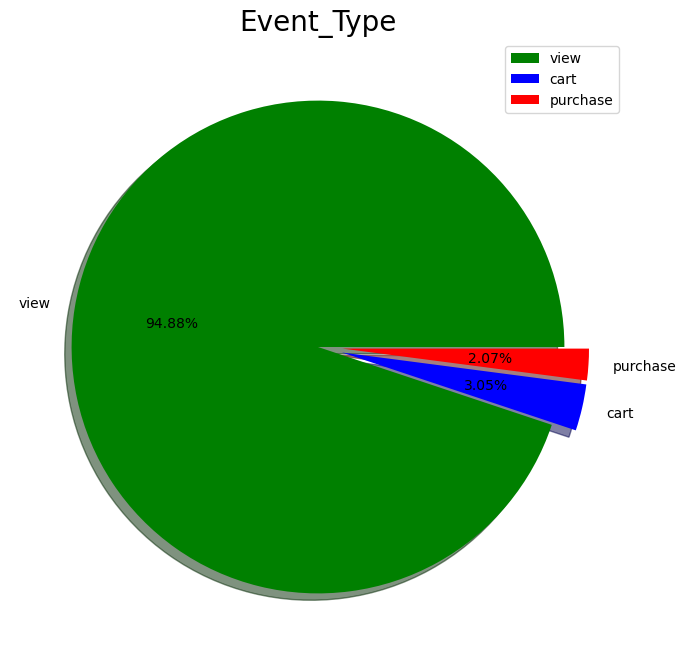

In [35]:
labels = ['view', 'cart','purchase']
size = data_cleaned['event_type'].value_counts()
colors = ['green', 'blue','red']
explode = [0, 0.1,0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event_Type', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

# Top 10 brands by event type

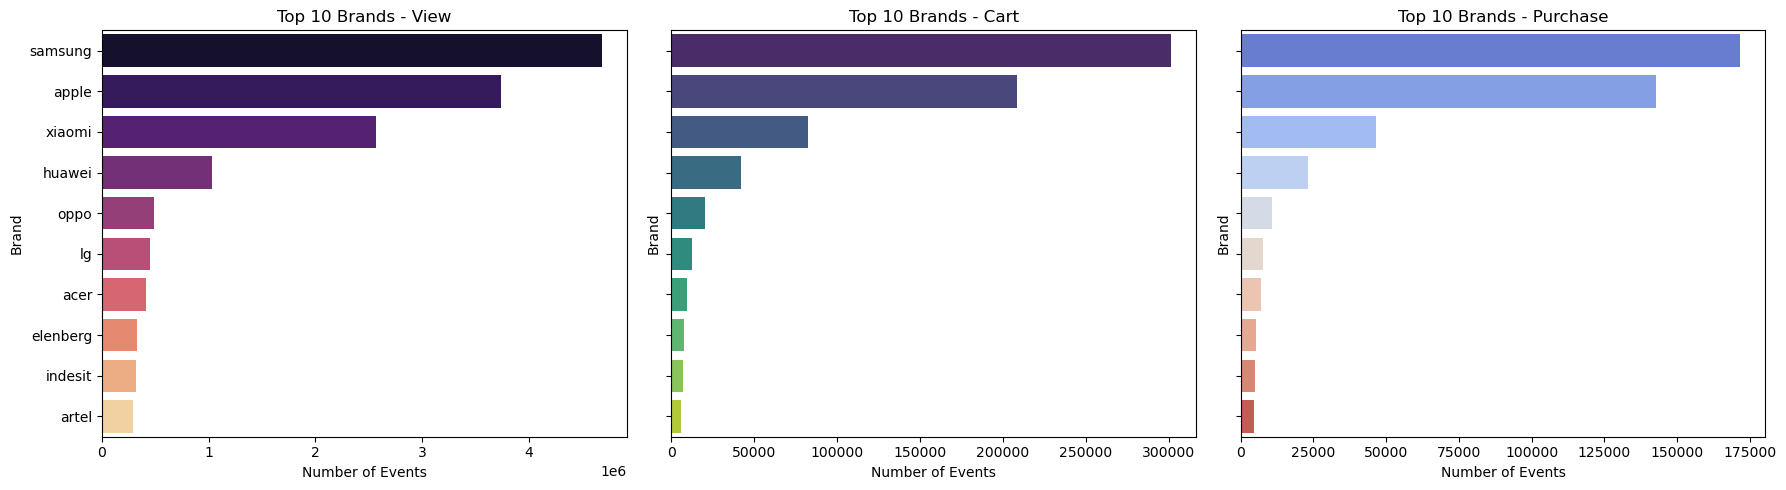

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
event_types = ['view', 'cart', 'purchase']
colors = ['magma', 'viridis', 'coolwarm']

top_brands_by_event = {event: data_cleaned[data_cleaned['event_type'] == event]['brand'].value_counts().head(10) for event in event_types}

for i, event in enumerate(event_types):
    sns.barplot(y=top_brands_by_event[event].index, x=top_brands_by_event[event].values, palette=colors[i], ax=axes[i])
    axes[i].set_title(f"Top 10 Brands - {event.capitalize()}")
    axes[i].set_xlabel("Number of Events")
    axes[i].set_ylabel("Brand")

plt.tight_layout()
plt.show()

# Top 10 popular categories

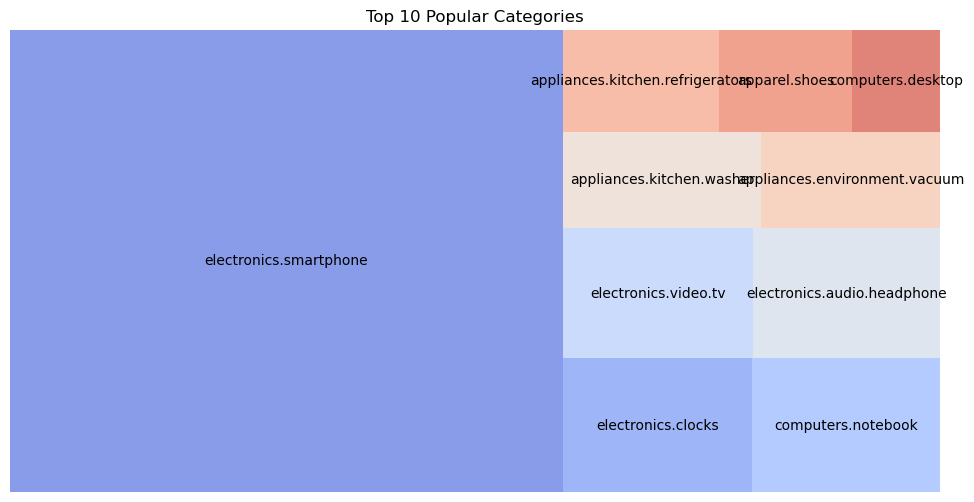

In [39]:
category_counts = data_cleaned['category_code'].value_counts().head(10)
plt.figure(figsize=(12, 6))
squarify.plot(sizes=category_counts.values, label=category_counts.index, alpha=0.7, color=sns.color_palette("coolwarm", 10))
plt.title("Top 10 Popular Categories")
plt.axis('off')
plt.show()


# Label Encoding 

In [40]:
mapping = {'view': 0, 'cart': 1, 'purchase': 2}
data_cleaned['event_type'] = data_cleaned['event_type'].map(mapping)
data_cleaned

,event_type,product_id,category_id,category_code,brand,price,year,month,day,dayofweek
1,0,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,2019,10,1,1
3,0,1307067,2053013558920217191,computers.notebook,lenovo,251.74,2019,10,1,1
4,0,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,2019,10,1,1
5,0,1480613,2053013561092866779,computers.desktop,pulser,908.62,2019,10,1,1
8,0,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,2019,10,1,1
...,...,...,...,...,...,...,...,...,...,...
42448757,0,1004870,2053013555631882655,electronics.smartphone,samsung,275.25,2019,10,31,3
42448758,0,2702331,2053013563911439225,appliances.kitchen.refrigerators,lg,527.43,2019,10,31,3
42448759,0,2300275,2053013560530830019,electronics.camera.video,gopro,527.40,2019,10,31,3
42448761,0,5701038,2053013553970938175,auto.accessories.player,kenwood,128.70,2019,10,31,3


# Countplotting based on the event_type

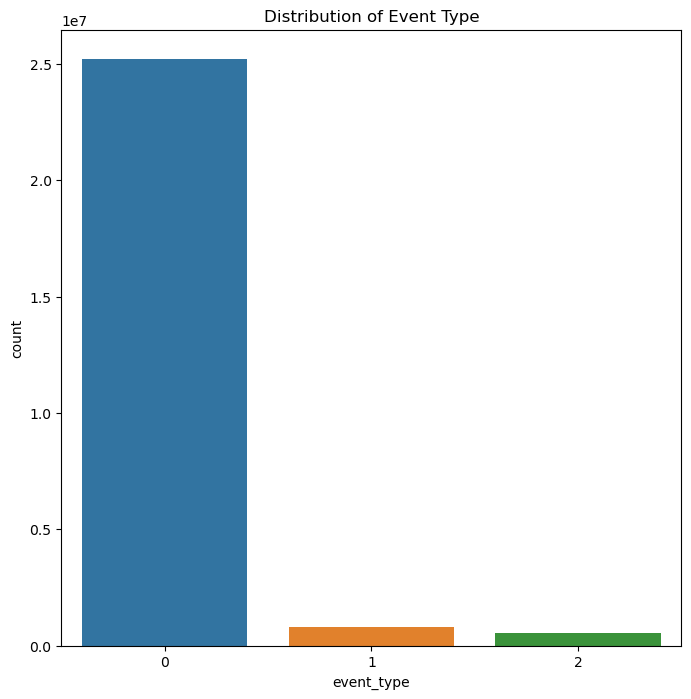

In [41]:
sns.countplot(x=data_cleaned['event_type'])
plt.title("Distribution of Event Type")
plt.show()

# Prepare the box plot

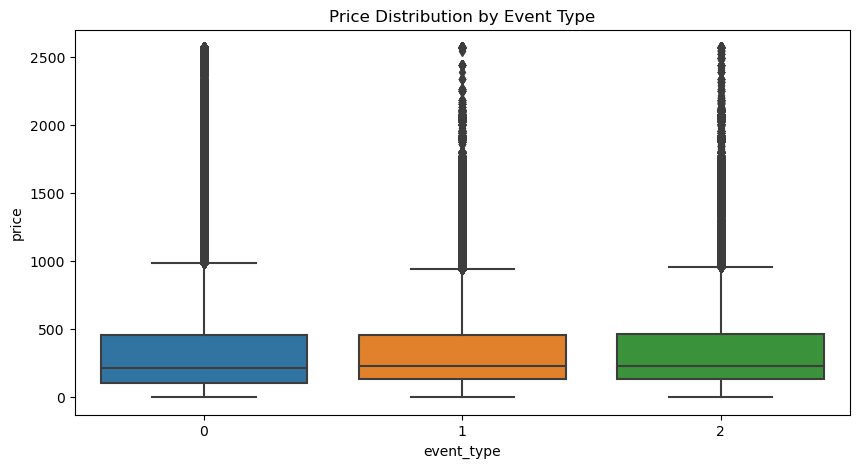

In [42]:
plt.figure(figsize=(10,5))
sns.boxplot(x='event_type', y='price', data=data_cleaned)
plt.title("Price Distribution by Event Type")
plt.show()


# Remove the outliers

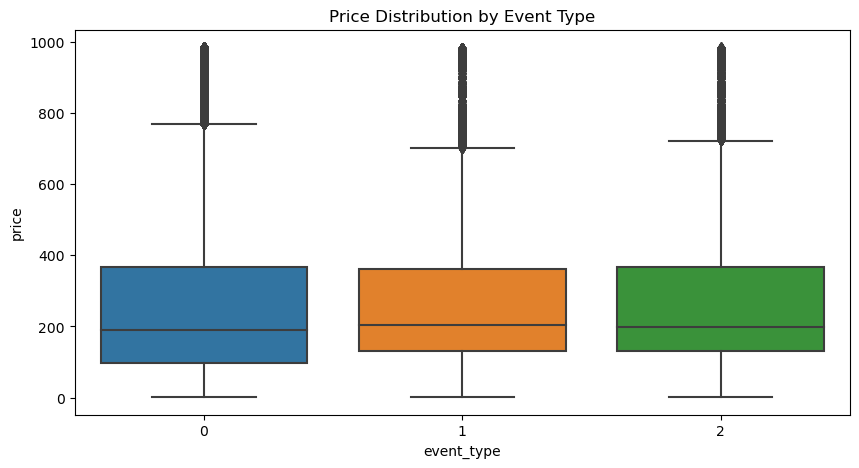

In [43]:
Q1 = data_cleaned['price'].quantile(0.25)
Q3 = data_cleaned['price'].quantile(0.75)

# Compute IQR
IQR = Q3 - Q1

# Define the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
data_cleaned = data_cleaned[(data_cleaned['price'] >= lower_bound) & (data_cleaned['price'] <= upper_bound)]


plt.figure(figsize=(10,5))
sns.boxplot(x='event_type', y='price', data=data_cleaned)
plt.title("Price Distribution by Event Type")
plt.show()


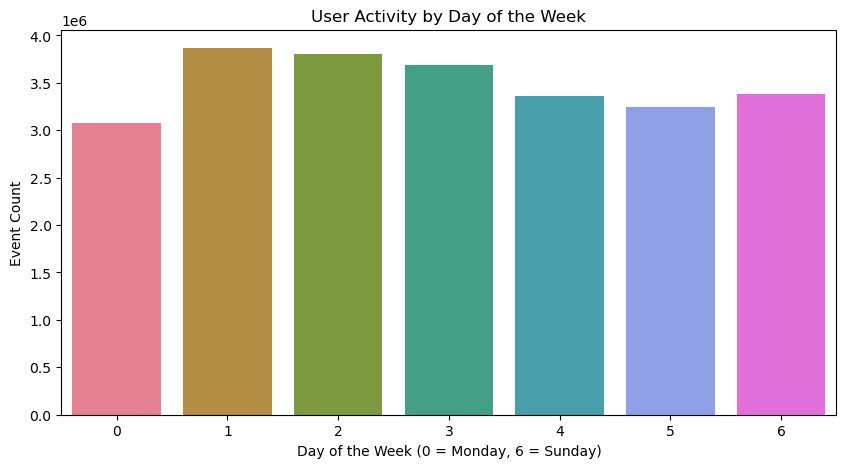

In [48]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data_cleaned, x='dayofweek', palette='husl')
plt.title("User Activity by Day of the Week")
plt.xlabel("Day of the Week (0 = Monday, 6 = Sunday)")
plt.ylabel("Event Count")
plt.show()